# Import Package

source : https://www.kaggle.com/c/GiveMeSomeCredit <br>
by Tito Tamaro<br>
sebagai _Final Project_ JCDS Purwadhika 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, auc, roc_auc_score, accuracy_score, balanced_accuracy_score,f1_score,recall_score,precision_score,classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
%matplotlib inline

# Functions

In [2]:
def dataframe_description(dataframe,samples=2): 
    bsDESC=[]
    for i in dataframe.columns:
        bsDESC.append([
            i, 
            dataframe[i].dtypes, 
            dataframe[i].isnull().sum(), 
            round((((dataframe[i].isnull().sum()) / (len(dataframe))) * 100),2),
            dataframe[i].nunique(), 
            dataframe[i].drop_duplicates().sample(samples).values,
            round(dataframe[i].mean(),2),
            round(dataframe[i].max(),2),
            round(dataframe[i].min(),2)
        ])
    dfDesc = pd.DataFrame(bsDESC,columns=['dataFeatures','dataType','nullValues','nullPercentage','unique','sample','mean','maxValues','minValues'])
    return dfDesc 

# Attributes Information

| Variable Name | Description | Type |
| --- | --- | --- |
|SeriousDlqin2yrs|Person experienced 90 days past due delinquency or worse|Y/N|
|RevolvingUtilizationOfUnsecuredLines|Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits|percentage|
|age|Age of borrower in years|integer|
|NumberOfTime30-59DaysPastDueNotWorse|Number of times borrower has been 30-59 days past due but no worse in the last 2 years.|integer|
|DebtRatio|Monthly debt payments| percentage|living costs divided by monthy gross income|percentage|
|MonthlyIncome|Monthly income|integer|
|NumberOfOpenCreditLinesAndLoans|Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)|integer|
|NumberOfTimes90DaysLate|Number of times borrower has been 90 days or more past due.|integer|
|NumberRealEstateLoansOrLines|Number of mortgage and real estate loans including home equity lines of credit|integer|
|NumberOfTime60-89DaysPastDueNotWorse|Number of times borrower has been 60-89 days past due but no worse in the last 2 years.|integer|
|NumberOfDependents|Number of dependents in family excluding themselves (spouse or children etc.)|integer|

Data merupakan kompetisi dari kaggle pada tahun 2011 (source: https://www.kaggle.com/c/GiveMeSomeCredit) dimana peserta diminta untuk memprediksi apakah peminjam uang akan mengalami _default_ (gagal bayar).

In [3]:
df_training = pd.read_csv('cs-training.csv')
df_training.rename(columns={'Unnamed: 0':'index'},inplace=True) # mengubah Unnamed features menjadi index
df_training = df_training.set_index('index')

df_test = pd.read_csv('cs-test.csv')
df_test.rename(columns={'Unnamed: 0':'index'},inplace=True) # mengubah Unnamed features menjadi index
df_test = df_test.set_index('index')

df_sample = pd.read_csv('sampleEntry.csv')

In [4]:
print(df_training.shape)
print(df_test.shape)
print(df_sample.shape)

(150000, 11)
(101503, 11)
(101503, 2)


## Data Description

In [5]:
dataframe_description(df_training)

,dataFeatures,dataType,nullValues,nullPercentage,unique,sample,mean,maxValues,minValues
0,SeriousDlqin2yrs,int64,0,0.00,2,"[0, 1]",0.07,1.0,0.0
1,RevolvingUtilizationOfUnsecuredLines,float64,0,0.00,125728,"[0.0035858709999999996, 0.15115576]",6.05,50708.0,0.0
2,age,int64,0,0.00,86,"[47, 55]",52.30,109.0,0.0
3,NumberOfTime30-59DaysPastDueNotWorse,int64,0,0.00,16,"[0, 1]",0.42,98.0,0.0
4,DebtRatio,float64,0,0.00,114194,"[0.308819995, 0.11465914199999999]",353.01,329664.0,0.0
5,MonthlyIncome,float64,29731,19.82,13594,"[4183.0, 9804.0]",6670.22,3008750.0,0.0
6,NumberOfOpenCreditLinesAndLoans,int64,0,0.00,58,"[48, 20]",8.45,58.0,0.0
7,NumberOfTimes90DaysLate,int64,0,0.00,19,"[8, 1]",0.27,98.0,0.0
8,NumberRealEstateLoansOrLines,int64,0,0.00,28,"[25, 5]",1.02,54.0,0.0
9,NumberOfTime60-89DaysPastDueNotWorse,int64,0,0.00,13,"[9, 98]",0.24,98.0,0.0


Dari deskripsi di atas, features dapat dikelompokkan menjadi :

- <b>Numerical Values</b>

    - RevolvingUtilizationOfUnsecuredLines
    - age
    - NumberOfTime30-59DaysPastDueNotWorse
    - DebtRatio
    - MonthlyIncome
    - NumberOfOpenCreditLinesAndLoans
    - NumberOfTimes90DaysLate
    - NumberRealEstateLoansOrLines
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfDependents
    
    
- <b>Categorical Values</b>

    - SeriousDlqin2yrs ==> <b>Target</b>

## Data Distribution

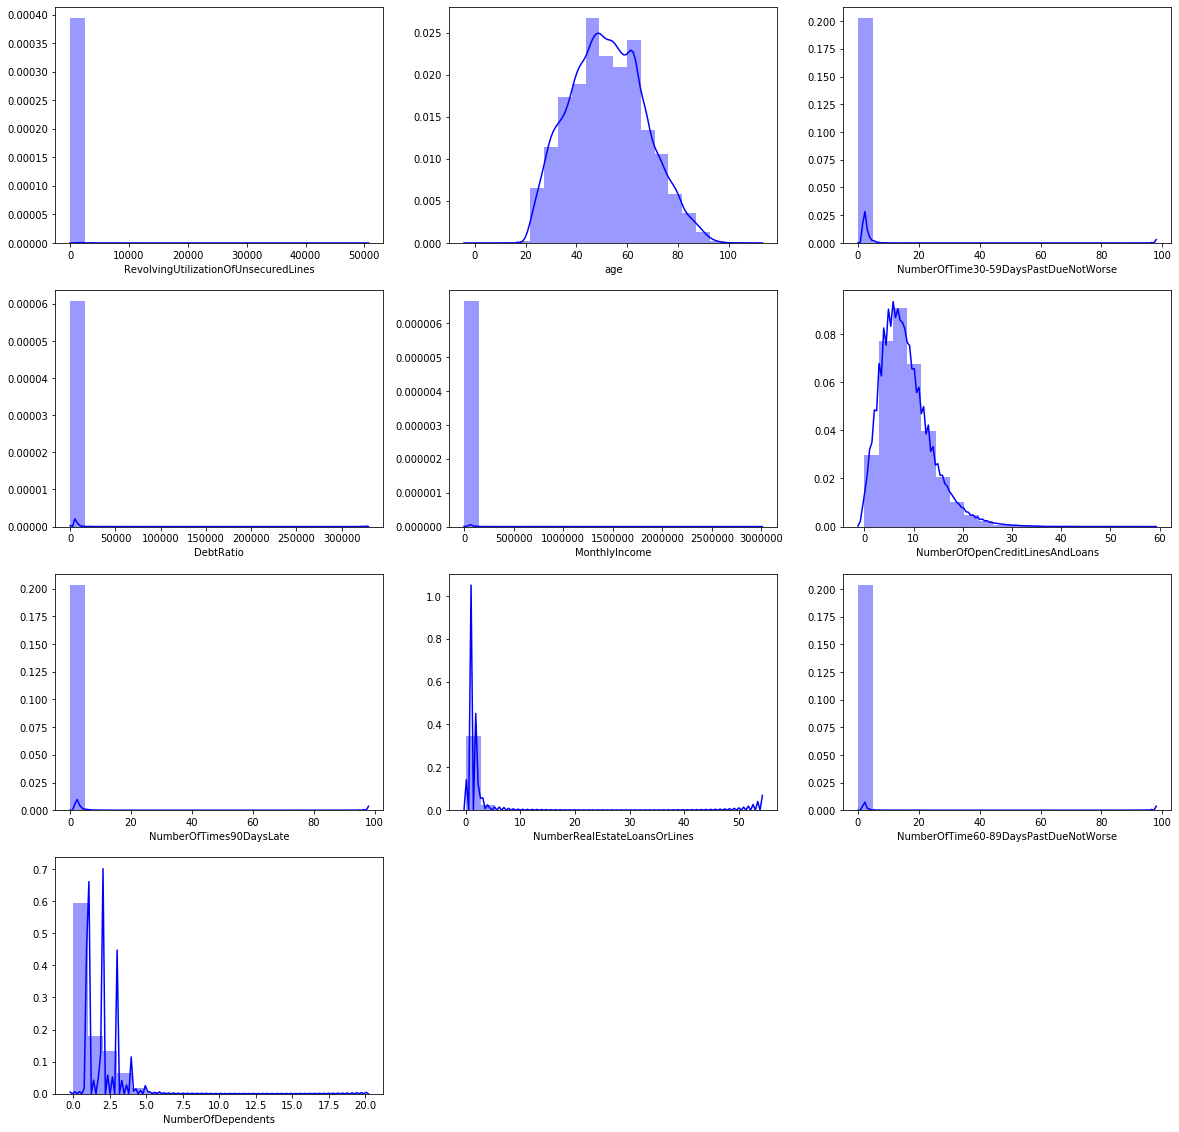

In [6]:
col = df_training.drop(['SeriousDlqin2yrs'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,11)):
    axes = fig.add_subplot(4,3,i)
    sns.distplot(df_training[j],bins=20,ax=axes, color='blue') # jumlah bins 1/10 jumlah data
plt.show()

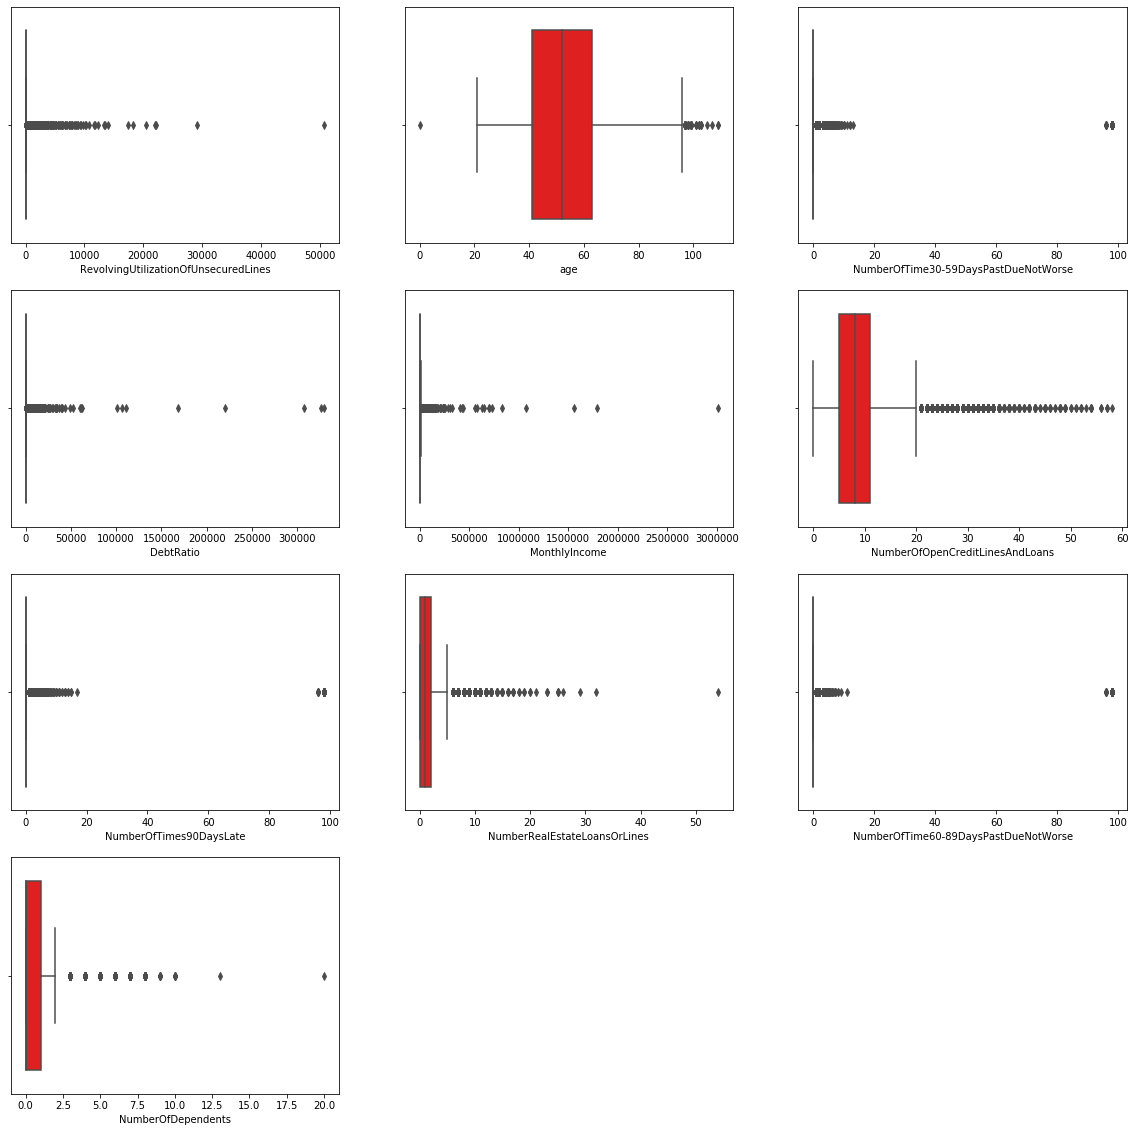

In [7]:
col = df_training.drop(['SeriousDlqin2yrs'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,11)):
    axes = fig.add_subplot(4,3,i)
    sns.boxplot(df_training[j],ax=axes, color='red')
plt.show()

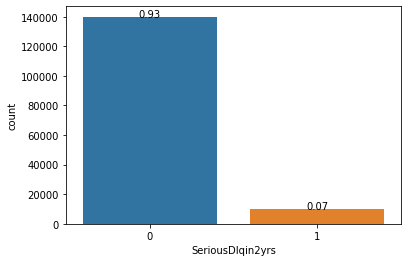

In [8]:
ax = sns.countplot(df_training['SeriousDlqin2yrs'])
total = len(df_training)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.show()

Imbalanced Target

# NaN Values

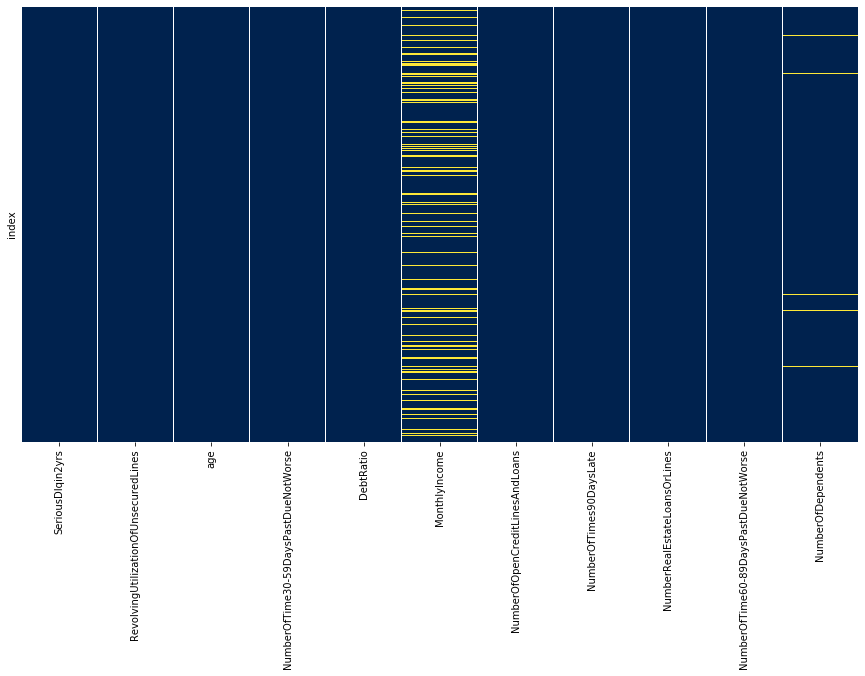

In [9]:
plt.figure(figsize=(15,8))

sns.heatmap(df_training.isna(), yticklabels=False, cmap='cividis', cbar=False)
plt.show()

In [10]:
df_training.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Sebelum dilakukan NaN values handling, akan dilakukan pengecekan terhadap data dan dilihat bagaimana pengaruhnya terhadap kolom target yaitu <b>SeriousDlqin2yrs</b>

In [11]:
df_training['nullValuesMI'] = pd.isnull(df_training['MonthlyIncome'])
df1 = pd.crosstab(index=df_training.nullValuesMI, columns=df_training.SeriousDlqin2yrs, values=df_training.nullValuesMI,aggfunc='count',normalize='all')
df1

SeriousDlqin2yrs,0,1
nullValuesMI,,
False,0.74608,0.055713
True,0.18708,0.011127


In [12]:
df_training['nullValuesND'] = pd.isnull(df_training['NumberOfDependents'])
df2 = pd.crosstab(index=df_training.nullValuesND, columns=df_training.SeriousDlqin2yrs, values=df_training.nullValuesND,aggfunc='count',normalize='all')
df2

SeriousDlqin2yrs,0,1
nullValuesND,,
False,0.908193,0.065647
True,0.024967,0.001193


NaN Value Handling akan dilakukan setelah Train Test Split untuk mencegah Data Leakage

## Outlier Handling

Outlier Handling yang akan dilakukan menggunakan upper fence dan lower fence sebagai batasannya dimana :<br> 
<b>IQR = Q3 - Q1<br>
Upper Fence = Q3 + 1.5 X IQR<br>
Lower Fence = Q1 - 1.5 x IQR</b><br>
Dimana nilai feature yang diatas Upper Fence dan dibawah Lower Fence akan dianggap sebagai <b>Outlier</b><br>
Jelas kondisinya akan disesuaikan dengan kondisi feature, dimana terdapat nilai outlier akan <b>dihapus / dibiarkan</b>.

### Outlier Handling for 'RevolvingUtilizationOfUnsecuredLines'

- <b>IQR Calculation</b>

In [13]:
IQR_RUUL = (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)) - (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)) # IQR
lower_fence_RUUL = (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)) - (1.5 * IQR_RUUL) # Q1 - 1.5 X IQR
upper_fence_RUUL = (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)) + (1.5 * IQR_RUUL) # Q3 + 1.5 X IQR
print(f'Lower Fence RUUL : {lower_fence_RUUL}')
print(f'Upper Fence RUUL : {upper_fence_RUUL}')

Lower Fence RUUL : -0.7639007662499999
Upper Fence RUUL : 1.35281445575


- <b>Filter Outliers</b>

In [14]:
jumlah_outlier_RUUL = len(df_training[df_training['RevolvingUtilizationOfUnsecuredLines'] < lower_fence_RUUL]) + len(df_training[df_training['RevolvingUtilizationOfUnsecuredLines'] > upper_fence_RUUL]) 
persen_RUUL = (jumlah_outlier_RUUL / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_RUUL} data ({persen_RUUL})%')

Jumlah Outlier yang akan dihandle adalah : 763 data (0.5086666666666666)%


- <b>Drop Outliers</b>

In [15]:
df_training.drop(df_training[df_training['RevolvingUtilizationOfUnsecuredLines']<lower_fence_RUUL].index,axis=0,inplace=True)
df_training.drop(df_training[df_training['RevolvingUtilizationOfUnsecuredLines']>upper_fence_RUUL].index,axis=0,inplace=True)

### Outlier Handling for 'age'

- <b>IQR Calculation</b>

In [16]:
IQR = (df_training['age'].quantile(0.75)) - (df_training['age'].quantile(0.25)) # IQR
lower_fence_age = (df_training['age'].quantile(0.25)) - (1.5 * IQR) # Q1 - 1.5 X IQR
upper_fence_age = (df_training['age'].quantile(0.75)) + (1.5 * IQR) # Q3 + 1.5 X IQR
print(f'Lower Fence age : {lower_fence_age}')
print(f'Upper Fence age : {upper_fence_age}')

Lower Fence age : 8.0
Upper Fence age : 96.0


- <b>Filter Outliers</b>

In [17]:
jumlah_outlier_age = len(df_training[df_training['age'] < lower_fence_age]) 
persen_age = (jumlah_outlier_age / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_age} data ({persen_age})%')

Jumlah Outlier yang akan dihandle adalah : 1 data (0.0006700751154204386)%


- <b>Drop Outliers</b>

In [18]:
df_training.drop(df_training[df_training['age']<lower_fence_age].index,axis=0,inplace=True)

### Outlier Handling for 'NumberOfTime30-59DaysPastDueNotWorse'

- <b>IQR Calculation</b>

In [19]:
IQR_NT3059 = (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.75)) - (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.25)) # IQR
lower_fence_NT3059 = (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.25)) - (1.5 * IQR_NT3059) # Q1 - 1.5 X IQR
upper_fence_NT3059 = (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.75)) + (1.5 * IQR_NT3059) # Q3 + 1.5 X IQR
print(f'Lower Fence NT3059 : {lower_fence_NT3059}')
print(f'Upper Fence NT3059 : {upper_fence_NT3059}')

Lower Fence NT3059 : 0.0
Upper Fence NT3059 : 0.0


Dapat dilihat bahwa Lower Fence dan Upper Fence adalah 0, hal ini disebabkan oleh nilai IQR yang 0. Nilai IQR ini disebabkan oleh banyaknya data bernilai 0 dalam features NumberOfTime30-59DaysPastDueNotWorse. Oleh karena itu outlier handling akan dilakukan secara manual.

- <b>Filter Outliers</b>

In [20]:
df_training['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     125562
1      15857
2       4521
3       1720
4        733
5        338
98       264
6        138
7         53
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

Dapat dilihat pada jumlah unik data (value_counts) pada features ini, bahwa terdapat value 96 dan 98. Kemungkinan besar ini merupakan typo (salah ketik) yang dilakukan oleh penyedia data. Features NumberOfTime30-59DaysPastDueNotWorse menunjukkan berapa kali pemilik kredit mengalami keterlambatan bayar dalam kurun waktu 30-59 hari, bila dihitung (96 * 50 hari) adalah 13 tahun yang mana mustahil, sehingga value features 96 dan 98 dihapus

- <b>Drop Outliers</b>

In [21]:
df_training.drop(df_training[df_training['NumberOfTime30-59DaysPastDueNotWorse']==96].index,axis=0,inplace=True)
df_training.drop(df_training[df_training['NumberOfTime30-59DaysPastDueNotWorse']==98].index,axis=0,inplace=True)

### Outlier Handling for 'DebtRatio'

- <b>IQR Calculation</b>

In [22]:
IQR_DR = (df_training['DebtRatio'].quantile(0.75)) - (df_training['DebtRatio'].quantile(0.25)) # IQR
lower_fence_DR = (df_training['DebtRatio'].quantile(0.25)) - (1.5 * IQR_DR) # Q1 - 1.5 X IQR
upper_fence_DR = (df_training['DebtRatio'].quantile(0.75)) + (1.5 * IQR_DR) # Q3 + 1.5 X IQR
print(f'Lower Fence DR : {lower_fence_DR}')
print(f'Upper Fence DR : {upper_fence_DR}')

Lower Fence DR : -0.862476942
Upper Fence DR : 1.90703183


- <b>Filter Outliers</b>

In [23]:
jumlah_outlier_DR = len(df_training[df_training['DebtRatio'] < lower_fence_DR]) + len(df_training[df_training['DebtRatio'] > upper_fence_DR])
persen_DR = (jumlah_outlier_DR / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_DR} data ({persen_DR})%')

Jumlah Outlier yang akan dihandle adalah : 31089 data (20.869722824518185)%


Jumlah data yang mejadi outlier adalah 31115 atau 20.85% dari keseluruhan data, karena jumlahnya yang banyak maka outlier <b>tidak akan di handling</b> karena dikhawatirkan akan mengubah data

### Outlier Handling for 'MonthlyIncome'

- <b>IQR Calculation</b>

In [24]:
IQR_MI = (df_training['MonthlyIncome'].quantile(0.75)) - (df_training['MonthlyIncome'].quantile(0.25)) # IQR
lower_fence_MI = (df_training['MonthlyIncome'].quantile(0.25)) - (1.5 * IQR_MI) # Q1 - 1.5 X IQR
upper_fence_MI = (df_training['MonthlyIncome'].quantile(0.75)) + (1.5 * IQR_MI) # Q3 + 1.5 X IQR
print(f'Lower Fence MI : {lower_fence_MI}')
print(f'Upper Fence MI : {upper_fence_MI}')

Lower Fence MI : -3875.0
Upper Fence MI : 15525.0


- <b>Filter Outliers</b>

In [25]:
jumlah_outlier_MI = len(df_training[df_training['MonthlyIncome'] < lower_fence_MI]) + len(df_training[df_training['MonthlyIncome'] > upper_fence_MI])
persen_MI = (jumlah_outlier_MI / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_MI} data ({persen_MI})%')

Jumlah Outlier yang akan dihandle adalah : 4846 data (3.253069471762202)%


Pada data Monthly Income tidak ditemukan nilai dibawah negatif, juga ditemukan nilai diatas nilai upper fence sebanyak 4879 buah. Hal ini masuk akal karena MonthlyIncome sangat bervariasi tergantung jabatan, pendidikan dll. oleh karena itu data <b>tidak akan di handling</b> 

### Outlier Handling for 'NumberOfOpenCreditLinesAndLoans'

- <b>IQR Calculation</b>

In [26]:
IQR_NOCLL = (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.75)) - (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.25)) # IQR
lower_fence_NOCLL = (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.25)) - (1.5 * IQR_NOCLL) # Q1 - 1.5 X IQR
upper_fence_NOCLL = (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.75)) + (1.5 * IQR_NOCLL) # Q3 + 1.5 X IQR
print(f'Lower Fence NOCLL : {lower_fence_NOCLL}')
print(f'Upper Fence NOCLL : {upper_fence_NOCLL}')

Lower Fence NOCLL : -4.0
Upper Fence NOCLL : 20.0


- <b>Filter Outliers</b>

In [27]:
jumlah_outlier_NOCLL = len(df_training[df_training['NumberOfOpenCreditLinesAndLoans'] < lower_fence_NOCLL]) + len(df_training[df_training['NumberOfOpenCreditLinesAndLoans'] > upper_fence_NOCLL])
persen_NOCLL = (jumlah_outlier_NOCLL / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_NOCLL} data ({persen_NOCLL})%')

Jumlah Outlier yang akan dihandle adalah : 3975 data (2.6683762175515384)%


Pada NumberOfOpenCreditLinesAndLoans tidak terdapat nilai negatif dan memungkinkan apabila jumlahnya diatas 20 buah oleh karena itu outlier pada data ini <b>tidak akan dihapus</b>

### Outlier Handling for 'NumberOfTimes90DaysLate'

- <b>IQR Calculation</b>

In [28]:
IQR_NT90 = (df_training['NumberOfTimes90DaysLate'].quantile(0.75)) - (df_training['NumberOfTimes90DaysLate'].quantile(0.25)) # IQR
lower_fence_NT90 = (df_training['NumberOfTimes90DaysLate'].quantile(0.25)) - (1.5 * IQR_NT90) # Q1 - 1.5 X IQR
upper_fence_NT90 = (df_training['NumberOfTimes90DaysLate'].quantile(0.75)) + (1.5 * IQR_NT90) # Q3 + 1.5 X IQR
print(f'Lower Fence NT90 : {lower_fence_NT90}')
print(f'Upper Fence NT90 : {upper_fence_NT90}')

Lower Fence NT90 : 0.0
Upper Fence NT90 : 0.0


Nilai IQR yang 0 disebabkan oleh banyaknya data bernilai 0

- <b>Filter Outliers</b>

In [29]:
df_training['NumberOfTimes90DaysLate'].value_counts()

0     141155
1       5146
2       1490
3        628
4        266
5        120
6         72
7         34
9         18
8         17
10         8
11         5
12         2
13         2
14         2
15         1
17         1
Name: NumberOfTimes90DaysLate, dtype: int64

### Outlier Handling for 'NumberRealEstateLoansOrLines'

- <b>IQR Calculation</b>

In [30]:
IQR_NRELL = (df_training['NumberRealEstateLoansOrLines'].quantile(0.75)) - (df_training['NumberRealEstateLoansOrLines'].quantile(0.25)) # IQR
lower_fence_NRELL = (df_training['NumberRealEstateLoansOrLines'].quantile(0.25)) - (1.5 * IQR_NRELL) # Q1 - 1.5 X IQR
upper_fence_NRELL = (df_training['NumberRealEstateLoansOrLines'].quantile(0.75)) + (1.5 * IQR_NRELL) # Q3 + 1.5 X IQR
print(f'Lower Fence NRELL : {lower_fence_NRELL}')
print(f'Upper Fence NRELL : {upper_fence_NRELL}')

Lower Fence NRELL : -3.0
Upper Fence NRELL : 5.0


- <b>Filter Outliers</b>

In [31]:
jumlah_outlier_NRELL = len(df_training[df_training['NumberRealEstateLoansOrLines'] < lower_fence_NRELL]) + len(df_training[df_training['NumberRealEstateLoansOrLines'] > upper_fence_NRELL])
persen_NRELL = (jumlah_outlier_NRELL / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_NRELL} data ({persen_NRELL})%')

Jumlah Outlier yang akan dihandle adalah : 790 data (0.5303187954379158)%


Pada data NumberRealEstateLoansOrLines sangat memungkingkan apabila terdapat data diatas nilai outlier, oleh karena itu data <b>tidak akan di handling</b> 

### Outlier Handling for 'NumberOfTime60-89DaysPastDueNotWorse'

- <b>IQR Calculation</b>

In [32]:
IQR_NT6089 = (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.75)) - (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.25)) # IQR
lower_fence_NT6089 = (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.25)) - (1.5 * IQR_NT6089) # Q1 - 1.5 X IQR
upper_fence_NT6089 = (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.75)) + (1.5 * IQR_NT6089) # Q3 + 1.5 X IQR
print(f'Lower Fence NT6089 : {lower_fence_NT6089}')
print(f'Upper Fence NT6089 : {upper_fence_NT6089}')

Lower Fence NT6089 : 0.0
Upper Fence NT6089 : 0.0


Nilai IQR yang 0 disebabkan oleh banyaknya data bernilai 0

- <b>Filter Outliers</b>

In [33]:
df_training['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

0     141845
1       5605
2       1060
3        301
4         98
5         33
6         15
7          6
8          2
11         1
9          1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

### Outlier Handling for 'NumberOfDependents'

- <b>IQR Calculation</b>

In [34]:
IQR_ND = (df_training['NumberOfDependents'].quantile(0.75)) - (df_training['NumberOfDependents'].quantile(0.25)) # IQR
lower_fence_ND = (df_training['NumberOfDependents'].quantile(0.25)) - (1.5 * IQR_ND) # Q1 - 1.5 X IQR
upper_fence_ND = (df_training['NumberOfDependents'].quantile(0.75)) + (1.5 * IQR_ND) # Q3 + 1.5 X IQR
print(f'Lower Fence ND : {lower_fence_ND}')
print(f'Upper Fence ND : {upper_fence_ND}')

Lower Fence ND : -1.5
Upper Fence ND : 2.5


- <b>Filter Outliers</b>

In [35]:
jumlah_outlier_ND = len(df_training[df_training['NumberOfDependents'] < lower_fence_ND]) + len(df_training[df_training['NumberOfDependents'] > upper_fence_ND])
persen_ND = (jumlah_outlier_ND / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_ND} data ({persen_ND})%')

Jumlah Outlier yang akan dihandle adalah : 13251 data (8.895258681452939)%


Jumlah data yang mejadi outlier adalah 13336 atau 8.89% dari keseluruhan data, karena jumlahnya yang banyak maka outlier <b>tidak akan di handling</b> karena dikhawatirkan akan mengubah data

## Outlier Handling Summary

In [36]:
data = [{
    'Upper Fence':f'{lower_fence_RUUL}',
    'Lower Fence':f'{upper_fence_RUUL}',
    'Jumlah Outlier yang di Handle':f'{jumlah_outlier_RUUL}'
},
    
{
    'Upper Fence':f'{lower_fence_age}',
    'Lower Fence':f'{upper_fence_age}',
    'Jumlah Outlier yang di Handle':f'{jumlah_outlier_age}'  
},
{
    'Upper Fence':f'{lower_fence_NT3059}',
    'Lower Fence':f'{upper_fence_NT3059}',
    'Jumlah Outlier yang di Handle': 2
},
{    
    'Upper Fence':f'{lower_fence_DR}',
    'Lower Fence':f'{upper_fence_DR}',
    'Jumlah Outlier yang di Handle':0
},
{    
     'Upper Fence':f'{lower_fence_MI}',
    'Lower Fence':f'{upper_fence_MI}',
    'Jumlah Outlier yang di Handle': 0
},
{    
     'Upper Fence':f'{lower_fence_NOCLL}',
    'Lower Fence':f'{upper_fence_NOCLL}',
    'Jumlah Outlier yang di Handle': 0
},
{    
     'Upper Fence':f'{lower_fence_NT90}',
    'Lower Fence':f'{upper_fence_NT90}',
    'Jumlah Outlier yang di Handle': 0
},
{    
     'Upper Fence':f'{lower_fence_NRELL}',
    'Lower Fence':f'{upper_fence_NRELL}',
    'Jumlah Outlier yang di Handle': 0
},
{    
     'Upper Fence':f'{lower_fence_NT6089}',
    'Lower Fence':f'{upper_fence_NT6089}',
    'Jumlah Outlier yang di Handle': 0
}, 
{    
  'Upper Fence':f'{lower_fence_ND}',
    'Lower Fence':f'{upper_fence_ND}',
    'Jumlah Outlier yang di Handle': 0
    
    }]

In [37]:
df_training2 = df_training.drop(['nullValuesMI','nullValuesND'],axis=1)
pd.DataFrame(data,index=df_training2.columns[1:])

,Upper Fence,Lower Fence,Jumlah Outlier yang di Handle
RevolvingUtilizationOfUnsecuredLines,-0.7639007662499999,1.35281445575,763
age,8.0,96.0,1
NumberOfTime30-59DaysPastDueNotWorse,0.0,0.0,2
DebtRatio,-0.862476942,1.90703183,0
MonthlyIncome,-3875.0,15525.0,0
NumberOfOpenCreditLinesAndLoans,-4.0,20.0,0
NumberOfTimes90DaysLate,0.0,0.0,0
NumberRealEstateLoansOrLines,-3.0,5.0,0
NumberOfTime60-89DaysPastDueNotWorse,0.0,0.0,0
NumberOfDependents,-1.5,2.5,0


## Feature Engineering - Binning Age

In [38]:
# Binning age by interval 10
bins = [-1,21,31,41,51,61,71,81,91,101,111] # binning dengan interval 10 kecuali yang pertama karena hanya ditemukan 1 data dengan age 0 (outlier)
label = ['(0-20)','(21-30)','(31-40)','(41-50)','(51-60)','(61-70)','(71-80)','(81-90)','(91-100)','(101-111)'] # label umur
df_training['binned_age']=pd.cut(df_training['age'],bins=bins,labels=label)
df_training[['age','MonthlyIncome','binned_age']].head()

,age,MonthlyIncome,binned_age
index,,,
1,45,9120.0,(41-50)
2,40,2600.0,(31-40)
3,38,3042.0,(31-40)
4,30,3300.0,(21-30)
5,49,63588.0,(41-50)


## Train Test Split

In [39]:
X = df_training.drop(columns='SeriousDlqin2yrs')
y = df_training['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X ,y ,stratify = y, train_size=.75, random_state=42) # data split

## Data Imputation

In [40]:
X_train['MonthlyIncome'] = X_train.groupby('binned_age')['MonthlyIncome'].apply(lambda x:x.fillna(x.median()))

In [41]:
X_train['NumberOfDependents'] = X_train.groupby('binned_age')['NumberOfDependents'].apply(lambda x:x.fillna(x.median()))

In [42]:
X_test['MonthlyIncome'] = X_test.groupby('binned_age')['MonthlyIncome'].apply(lambda x:x.fillna(x.median()))

In [43]:
X_test['NumberOfDependents'] = X_test.groupby('binned_age')['NumberOfDependents'].apply(lambda x:x.fillna(x.median()))

## Feature Selection

In [44]:
df_training.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'nullValuesMI', 'nullValuesND', 'binned_age'],
      dtype='object')

In [45]:
X_train.drop(['nullValuesMI','nullValuesND','binned_age'],axis=1,inplace=True)

In [46]:
X_test.drop(['nullValuesMI','nullValuesND','binned_age'],axis=1,inplace=True)

## Data Imbalanced Handling

 _<b>SMOTE</b>_

In [47]:
sm = SMOTE(random_state=42)
X_train_sm,y_train_sm=sm.fit_sample(X_train,y_train)

_<b>Oversampling<b>_

In [48]:
X = pd.concat([X_train, y_train], axis=1)

not_default = X[X.SeriousDlqin2yrs == 0]
default = X[X.SeriousDlqin2yrs == 1]

In [49]:
default_oversample = resample(default,
                            replace = True,
                            n_samples = len(not_default),
                            random_state=42
)

In [50]:
oversampled = pd.concat([not_default,default_oversample])

In [51]:
oversampled.SeriousDlqin2yrs.value_counts() # sudah sama jumlahnya

1    104492
0    104492
Name: SeriousDlqin2yrs, dtype: int64

In [52]:
X_train_os = oversampled.drop(columns='SeriousDlqin2yrs',axis=1)
y_train_os = oversampled.SeriousDlqin2yrs

_<b>Undersampling</b>_

In [53]:
X2 = pd.concat([X_train, y_train], axis=1)

not_default = X2[X2.SeriousDlqin2yrs == 0]
default = X2[X2.SeriousDlqin2yrs == 1]

In [54]:
not_default_undersample = resample(not_default,
                            replace = False,
                            n_samples = len(default),
                            random_state=42
)

In [55]:
undersampled = pd.concat([not_default_undersample,default])

In [56]:
undersampled.SeriousDlqin2yrs.value_counts() # datanya sudah dikurangi hingga jumlahnya sama

1    7233
0    7233
Name: SeriousDlqin2yrs, dtype: int64

In [57]:
X_train_us = undersampled.drop(columns='SeriousDlqin2yrs',axis=1)
y_train_us = undersampled.SeriousDlqin2yrs

Hyper Parameter Tuning merupakan proses yang sangat memakan waktu, oleh karena itu pencarian parameter terbaik tidak bisa dilakukan di 36 algoritma ini. Sehingga akan dipilih hasil terbaik dari masing-masing algoritma dan kemudian di tuning, algoritma yang akan dituning adalah :
- XGBC Robust - SMOTE

## Pipeline Creation - Hyper Parameter Tuning

In [64]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("xgbc", XGBClassifier(
    max_depth=15, # semakin besar akan overfit, default 3
    learning_rate=0.03, # semakin besar akan underfit, default 0.1
    n_estimators=2000, # semakin besar akan overfit, default 100
    min_child_weight=1, # berfungsi untuk regularisasi, default 1 
    ))
])

## Hyper Parameter Tuning Model 1 - Better Params

In [65]:
pipeline1.fit(X_train_sm,y_train_sm)

Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.03,
                               max_delta_step=0, max_depth=15,
                               min_child_weight=1, missing=None,
                               n_estimators=2000, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [66]:
pipeline1.score(X_test,y_test)

0.9356103324203856

In [67]:
prediksi1 = pipeline1.predict(X_test)

In [68]:
print(classification_report(y_test,prediksi1))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     34831
           1       0.51      0.20      0.29      2411

    accuracy                           0.94     37242
   macro avg       0.73      0.59      0.63     37242
weighted avg       0.92      0.94      0.92     37242



In [69]:
cm = confusion_matrix(y_test,prediksi1,labels=[1,0])
print(cm)

[[  480  1931]
 [  467 34364]]


In [70]:
TP1,FN1,FP1,TN1 = cm[0,0],cm[0,1],cm[1,0],cm[1,1]

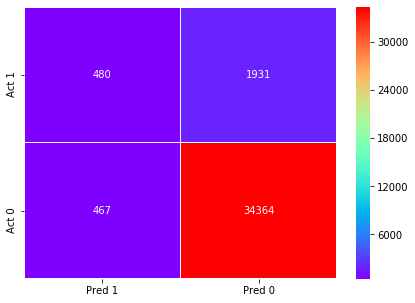

In [71]:
df_cm = pd.DataFrame(cm,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])

plt.figure(figsize=(7,5))
x = sns.heatmap(df_cm, annot=True,annot_kws={'size':10},fmt='d',linewidths=0.2,cmap='rainbow')
x.set_ylim(2,0)
plt.show()

## ROC-AUC Curve

In [73]:
proba1 = pipeline1.predict_proba(X_test)

In [74]:
pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

In [75]:
sc1 = round(auc(fpr1,tpr1),3)

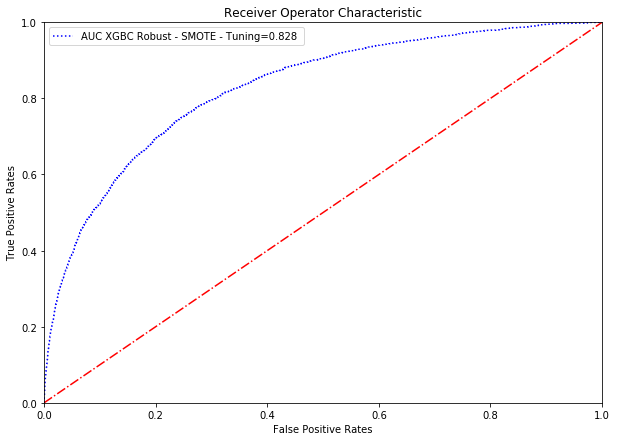

In [76]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC XGBC Robust - SMOTE - Tuning={sc1} ')

plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend()
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [77]:
list_of_sc=[sc1]

In [78]:
list_of_algo=[
    'AUC XGBC Robust - SMOTE'
]

In [79]:
list_of_TP=[TP1]
list_of_FP=[FP1]
list_of_TN=[TN1]
list_of_FN=[FN1]

In [80]:
accuracy = [round(accuracy_score(y_test,prediksi1),2)]
precision = [round(precision_score(y_test,prediksi1),2)]
recall = [round(recall_score(y_test,prediksi1),2)]

In [81]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,accuracy,precision,recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Akurasi','Precision','Recall'])

In [82]:
df_AUC.sort_values(by='Nilai AUC',ascending=False)

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Akurasi,Precision,Recall
0,AUC XGBC Robust - SMOTE,0.828,480,467,34364,1931,0.94,0.51,0.2
